In [ ]:
"""
Created on 2019/2/25

Variational Auto-encoder implementation

Ref:
Keras Team
1. https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
2. https://blog.keras.io/building-autoencoders-in-keras.html
Blog
1. https://github.com/bojone/vae/blob/master/vae_keras.py
2. https://zhuanlan.zhihu.com/p/34998569
"""

# Import

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

Using TensorFlow backend.


# Data preparation

In [3]:
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = to_categorical(y_train_, num_classes)
y_test = to_categorical(y_test_, num_classes)

# Create a network

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            514         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            514         dense_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

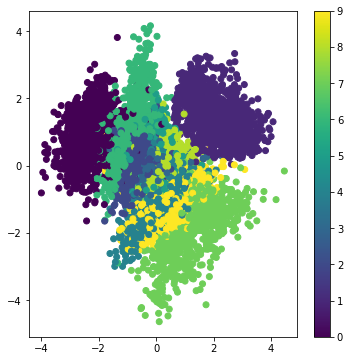

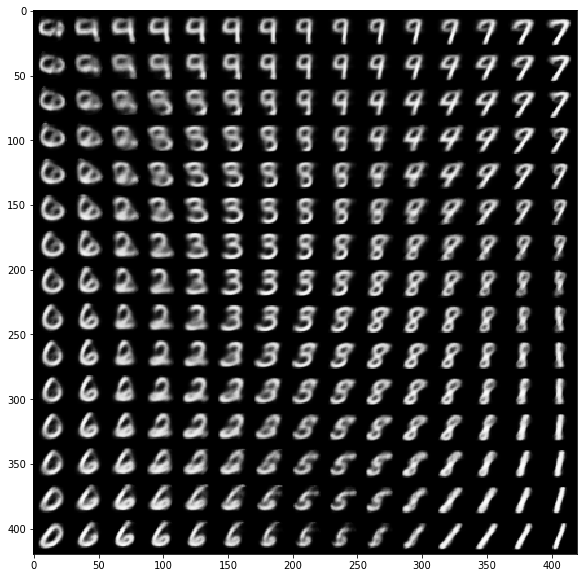

In [20]:
batch_size = 100
original_dim = 784
latent_dim = 2 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0
num_classes = 10

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# reparameterization: 
def sampling(args):
    z_mean, z_log_var = args
    # 從N(mu, sigma^2)抽一個sample Z，相當於從N(0, 1)抽出一個epsilon，然後讓Z= mu + epsilon * sigma
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)  # epsilon_std=1
    # by default, random_normal has mean = 0 and std = 1.0
    # epsilon = K.random_normal(shape=(batch, dim))
    # instead of sampling from Q(z|X), sample epsilon = N(0,I)
    # z = z_mean + sqrt(var) * epsilon
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')  # intermediate_dim=256
decoder_mean = Dense(original_dim, activation='sigmoid')  # 784
h_decoded = decoder_h(z) # latent -> intermediate
x_decoded_mean = decoder_mean(h_decoded) # intermediate -> original

# 建立模型
vae = Model(x, x_decoded_mean)

# xent_loss是重构loss，kl_loss是KL loss
# 重構Loss和KL loss拮抗，KL loss是為了讓latent更像normal?
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
# Reparameterization Trick
# z_mean和z_log_var是透過一組參數乘來的，所以透過下列式子訓練讓他們逼近Normal(0, 1)
# http://skyhigh233.com/blog/2018/04/05/vae/
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


# 构建encoder，然后观察各个数字在隐空间的分布
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# 观察隐变量的两个维度变化是如何影响输出结果的
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

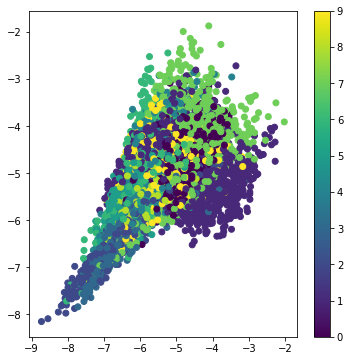

In [30]:
# Model可擺在訓練完之後!! 原來權重會繼續留著～～
encoder_var = Model(x, z_log_var)

x_test_encoded = encoder_var.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

In [32]:
y_test_.shape

(10000,)